### This notebook generates the SD-CAPE relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [4]:
# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
#capepre_array = nc_open_compile(file_years,"capepre")
#capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]
#capepre9_array = nc_open_compile(file_years,"capepre9")
#capepre9_ERAI = negative_to_nan(capepre9_array)[tropical_indx]

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]
qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
qvpre_ERAI = negative_to_nan(qvpre_array)[tropical_indx]
qvpre6_array = nc_open_compile( file_years, "qvpre6", 'stack' )
qvpre6_ERAI = negative_to_nan(qvpre6_array)[tropical_indx]
qvpre9_array = nc_open_compile( file_years, "qvpre9", 'stack' )
qvpre9_ERAI = negative_to_nan(qvpre9_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

In [5]:
# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
sd850pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000
i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd700pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*100
i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd550pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3
sdpre_ERAI = (sd850pre_ERAI + sd700pre_ERAI + sd550pre_ERAI)/3
print( 'Min, Mean, and Max SD [g kg-1]: ' + str(np.nanmin(sd_ERAI)) + ' ' + str(np.nanmedian(sd_ERAI)) + ' ' + str(np.nanmax(sd_ERAI)) )

Min, Mean, and Max SD [g kg-1]: -8.195535603071171 2.9261935177338905 12.085021871113057


### What does the probability distribution of saturation deficits look like?

[1.33333333 1.66666667 2.         2.33333333 2.66666667 3.
 3.33333333 3.66666667]
[6.11715088 7.07738041 7.65998675 7.71662304 7.50057139 6.92371494
 6.20383028 5.5203136 ]
54.71957128912621


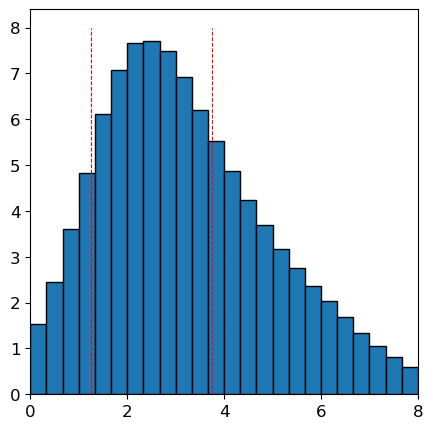

In [6]:
fig = plt.figure( figsize=(5,5) )
wgts = np.ones_like( sd_ERAI )/float(len(sd_ERAI))*100.
h, edges = np.histogram( sd_ERAI, bins=np.linspace(0,8,25), weights=wgts )
print(edges[4:12]) # 4:12 represent bins for SD = 1.25-3.75 g kg-1
print(h[4:12])
print(np.cumsum(h[4:12])[-1])
plt.hist( sd_ERAI, bins=np.linspace(0,8,25), weights=wgts, edgecolor='k' )
plt.plot( [1.25, 1.25], [0, 8], lw=0.75, ls='--', color='red' )
plt.plot( [3.75, 3.75], [0, 8], lw=0.75, ls='--', color='red' )
plt.xlim( [0,8] )
plt.show()

In [7]:
pc2 = 99
nbin = 35

# create bins for *positive* saturation deficits and evaluate corresponding CAPE percentiles
sd_bins, cape_vals, cape_95_vals, cape_99_vals, sd_error, cape_error, sd_max, cape_max = \
    bin_stat_function( nbin, 0, 8, sd_ERAI, cape_ERAI, pc2=pc2, threshold=100 )

In [8]:
# create bins in SD and evaluate corresponding CAPE percentiles for longest-lived systems
sd_bins_old, cape_vals_old, _, cape_99_vals_old, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sd_ERAI[lifetime_ERAI > 12], cape_ERAI[lifetime_ERAI > 12], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for shortest-lived systems
sd_bins_young, cape_vals_young, _, cape_99_vals_young, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sd_ERAI[lifetime_ERAI <= 3], cape_ERAI[lifetime_ERAI <= 3], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for smallest systems
sd_bins_small, cape_vals_small, _, cape_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sd_ERAI[maxrad_ERAI <= 150], cape_ERAI[maxrad_ERAI <= 150], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for largest systems
sd_bins_large, cape_vals_large, _, cape_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sd_ERAI[maxrad_ERAI > 250], cape_ERAI[maxrad_ERAI > 250], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for deepest systems
sd_bins_deep, cape_vals_deep, _, cape_99_vals_deep, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sd_ERAI[minctt_ERAI <= 185], cape_ERAI[minctt_ERAI <= 185], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for shallowest systems
sd_bins_shallow, cape_vals_shallow, _, cape_99_vals_shallow, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sd_ERAI[minctt_ERAI > 205], cape_ERAI[minctt_ERAI > 205], pc2=pc2, threshold=100 )

In [9]:
sdpre_bins, cape_vals2, _, cape_99_vals2, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sdpre_ERAI, cape_ERAI, pc2=pc2, threshold=100 )

sd_bins2, capepre_vals, _, capepre_99_vals, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sd_ERAI, capepre6_ERAI, pc2=pc2, threshold=100 )

sdpre_bins2, capepre_vals2, _, capepre_99_vals2, _, _, _, _ = \
    bin_stat_function( nbin, 0, 8, sdpre_ERAI, capepre6_ERAI, pc2=pc2, threshold=100 )

In [14]:
print(sd_bins)

[0.12496903 0.35918429 0.59364044 0.82819792 1.06255691 1.297786
 1.53191014 1.76615466 2.00095532 2.23586725 2.46992849 2.70501523
 2.94023494 3.17575147 3.41060322 3.64548446 3.88071127 4.11563072
 4.35074861 4.58567727 4.82149507 5.05687489 5.29200831 5.52761896
 5.76253669 5.99820299 6.23130325 6.46831844 6.70138473 6.9387956
 7.17166047 7.40874941 7.64227292 7.87751656        nan]


### Figure 6 - Binning of CAPE and saturation deficit across percentiles

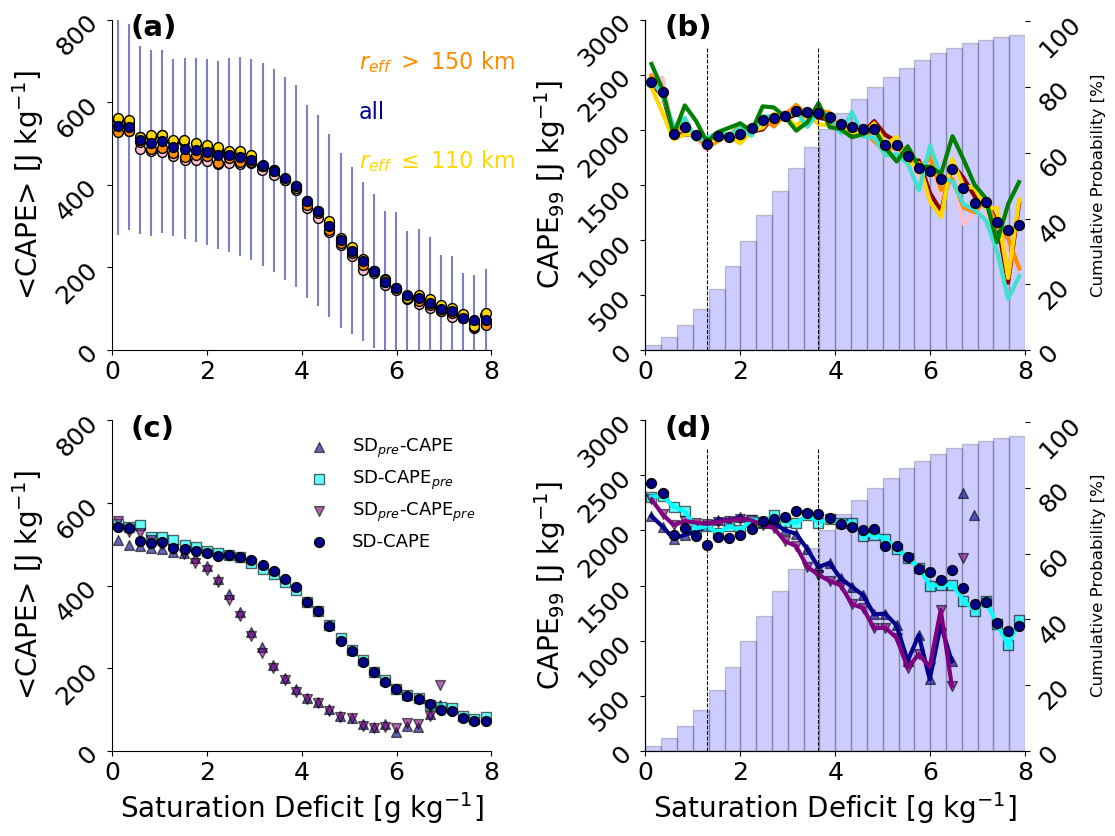

In [23]:
fig, ax = plt.subplots( 2, 2, figsize =(11.5, 8.7) )

ylab = [ r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]', r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]',
         r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]']
labels = [ '', '',  r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 8] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    #axis.get_xticks().set_rotation(45)
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    aaa=0.6
    if i == 0:
        axis.errorbar( sd_bins, cape_vals, xerr=sd_error/2, yerr=cape_error/2, color = 'darkblue', ls='none', zorder=0, 
                     alpha=0.5 )
        axis.scatter( sd_bins_old, cape_vals_old, s=50, color='pink', edgecolor='k' )
        axis.scatter( sd_bins_young, cape_vals_young, s=50, color='darkred', edgecolor='k' )
        axis.scatter( sd_bins_large, cape_vals_large, s=50, color='darkorange', edgecolor='k' )
        axis.scatter( sd_bins_small, cape_vals_small, s=50, color='gold', edgecolor='k' )
        axis.scatter( sd_bins, cape_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.text( 0.65, 0.55, r'$r_{eff}$ $\leq$ 110 km', transform=axis.transAxes, color='gold', fontsize=16 )
        axis.text( 0.65, 0.7, r'all', transform=axis.transAxes, color='darkblue', fontsize=16 )
        axis.text( 0.65, 0.85, r'$r_{eff}$ $>$ 150 km', transform=axis.transAxes, color='darkorange', fontsize=16 )
        axis.set_ylim([0, 800])
    elif i == 1:
        wgts = np.ones_like( sd_ERAI )/float(len(sd_ERAI))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        axis2.hist( sd_ERAI, bins=np.linspace(0, 8, 25), cumulative=True, weights=wgts, alpha=0.2, edgecolor='k', color='blue' )
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_axisbelow( True )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=12 )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        
        axis.plot( sd_bins_old, cape_99_vals_old, color='pink', lw=3 )
        axis.plot( sd_bins_young, cape_99_vals_young, color='darkred', lw=3 )
        axis.plot( sd_bins_large, cape_99_vals_large, color='darkorange', lw=3 )
        axis.plot( sd_bins_small, cape_99_vals_small, color='gold', lw=3 )
        axis.plot( sd_bins_deep, cape_99_vals_deep, color='turquoise', lw=3 )
        axis.plot( sd_bins_shallow, cape_99_vals_shallow, color='green', lw=3 )
        axis.plot( [1.2977, 1.2977], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.plot( [3.645, 3.645], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.scatter( sd_bins, cape_99_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.set_ylim([0, 3000])
    elif i == 2:
        axis.scatter( sdpre_bins, cape_vals2, s=50, marker='^', color='darkblue', alpha=aaa, edgecolor='k',
                    label=r'SD$_{pre}$-CAPE')
        axis.scatter( sd_bins, capepre_vals, s=50, marker='s', color='cyan', alpha=aaa, edgecolor='k',
                    label=r'SD-CAPE$_{pre}$')
        axis.scatter( sdpre_bins2, capepre_vals2, s=50, marker='v', color='purple', alpha=aaa, edgecolor='k',
                    label=r'SD$_{pre}$-CAPE$_{pre}$')
        axis.scatter( sd_bins, cape_vals, s=50, color='darkblue', edgecolor='k', label='SD-CAPE' )
        axis.legend( frameon=False, fontsize=13, loc='upper right' )
        axis.set_ylim([0, 800])
    elif i == 3:
        wgts = np.ones_like( sd_ERAI )/float(len(sd_ERAI))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        axis2.hist( sd_ERAI, bins=np.linspace(0, 8, 25), cumulative=True, weights=wgts, alpha=0.2, edgecolor='k', color='blue' )
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_axisbelow( True )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=12 )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        
        axis.scatter( sdpre_bins, cape_99_vals2, s=50, marker='^', color='darkblue', alpha=aaa, edgecolor='k' )
        axis.plot( sdpre_bins[0:-7], cape_99_vals2[0:-7], color='darkblue', lw=3 )
        axis.scatter( sd_bins, capepre_99_vals, s=50, marker='s', color='cyan', alpha=aaa, edgecolor='k' )
        axis.plot( sd_bins, capepre_99_vals, color='cyan', lw=3 )
        axis.scatter( sdpre_bins2, capepre_99_vals2, s=50, marker='v', color='purple', alpha=aaa, edgecolor='k' )
        axis.plot( sdpre_bins2[:-7], capepre_99_vals2[:-7], color='purple', lw=3 )
        axis.plot( [1.2977, 1.2977], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.plot( [3.645, 3.645], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.scatter( sd_bins, cape_99_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.set_ylim([0, 3000])


plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-ERAI-percentiles.pdf', bbox_inches='tight' )
plt.show()

In [11]:
# What are the slopes of linear regressions of SDpre-CAPE, SD-CAPEpre, etc.?
i = np.argwhere( (~np.isnan(sdpre_bins)) & (~np.isnan(cape_vals2)) )
out = scipy.stats.linregress( x=sdpre_bins[i[:,0]], y=cape_vals2[i[:,0]] )
print(out)
print(out.slope)

i = np.argwhere( (~np.isnan(sd_bins)) & (~np.isnan(cape_vals)) )
out = scipy.stats.linregress( x=sd_bins[i[:,0]], y=cape_vals[i[:,0]] )
print(out)

LinregressResult(slope=-82.92573337077066, intercept=546.4398324372471, rvalue=-0.9504182131512721, pvalue=9.802370376074502e-16, stderr=5.127675269597478, intercept_stderr=20.86599241268901)
-82.92573337077066
LinregressResult(slope=-69.83222018715998, intercept=606.4576553927072, rvalue=-0.9739119501476381, pvalue=3.5081031860013755e-22, stderr=2.876377361084568, intercept_stderr=13.278337353063035)


In [32]:
# What are the slopes of linear regressions of SD-CAPE99 for the range of ZBP behavior?
print(sd_bins)
sd_zbp = sd_bins[5:17]
cape99_zbp = cape_99_vals[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

sd_zbp = sd_bins_small[5:17]
cape99_zbp = cape_99_vals_small[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_large[5:17]
cape99_zbp = cape_99_vals_large[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_old[5:17]
cape99_zbp = cape_99_vals_old[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_young[5:17]
cape99_zbp = cape_99_vals_young[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_shallow[5:17]
cape99_zbp = cape_99_vals_shallow[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_deep[5:17]
cape99_zbp = cape_99_vals_deep[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

[0.12496903 0.35918429 0.59364044 0.82819792 1.06255691 1.297786
 1.53191014 1.76615466 2.00095532 2.23586725 2.46992849 2.70501523
 2.94023494 3.17575147 3.41060322 3.64548446 3.88071127 4.11563072
 4.35074861 4.58567727 4.82149507 5.05687489 5.29200831 5.52761896
 5.76253669 5.99820299 6.23130325 6.46831844 6.70138473 6.9387956
 7.17166047 7.40874941 7.64227292 7.87751656        nan]
LinregressResult(slope=113.28162590926544, intercept=1759.184341650337, rvalue=0.919592254380394, pvalue=2.310103796882405e-05, stderr=15.304445761631097, intercept_stderr=41.511210478147234)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
82.57075294874782
126.16503240956453
116.87458487277452
100.7118768423166
62.68979886204972
83.58846724273869
